In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import seaborn as sns
import numpy as np


### Cargar Datos

In [2]:
df = pd.read_csv('2022 MLB Player Stats - Pitching.csv', delimiter=';')

## Ejercicio 1

### Relación lineal o monótona con la variable **FIP**.

#### Filtrado de los datos

In [3]:
al = df.loc[df['Lg'] == 'AL']
al120h = al.loc[al['H'] > 120]

al120h_num = al120h.select_dtypes(include=[np.number])

#### Chequeo de supuestos

In [4]:
def check_assumptions(model, X):
    resid = model.resid
    X = sm.add_constant(X)
    assumptions = True

    # Media de los residuos
    mn = np.mean(resid)
    assumptions = assumptions and (abs(mn) < 0.05)

    # Independencia de los residuos
    # Prueba de Durbin-Watson
    dw = durbin_watson(resid)
    assumptions = assumptions and (dw > 1.5 and dw < 2.5)
    
    # Homocedasticidad
    # Prueba de Breusch-Pagan
    bp = het_breuschpagan(resid, X)
    assumptions = assumptions and (bp[1] > 0.05)

    # Normalidad de los residuos
    # Prueba de Shapiro-Wilk
    sw = shapiro(resid)
    assumptions = assumptions and (sw[1] > 0.05)

    return assumptions

#### Comparacion de modelos

In [5]:
def compare_models(model1, model2):
    # Calcular R-cuadrado ajustado
    r1_adj = model1.rsquared_adj
    r2_adj = model2.rsquared_adj

    # Calcular la raíz del error cuadrático medio (RMSE)
    rmse1 = np.sqrt(model1.mse_model)
    rmse2 = np.sqrt(model2.mse_model)

    return (r1_adj > r2_adj) and (rmse1 < rmse2)

#### Seleccion paso a paso 

In [6]:
def stepwise(df, var, t_values=3):
    not_used = order_by_correlation(df, var)
    used = [] + [not_used[0]]
    not_used = not_used[1:]
    X = [df[used[0]]]
    X = pd.concat(X, axis=1)
    y = df[var]
    model = sm.OLS(y, X).fit()
    for i in range(0, len(not_used)-1):
        new_X = [df[variable] for variable in used + [not_used[i]]]
        new_X = pd.concat(new_X, axis=1)
        new_model = sm.OLS(y, new_X).fit()
        if compare_models(new_model, model):
            used = used + [not_used[i]]
            not_used = not_used[:i] + not_used[i+1:]
            model = new_model
            X = new_X   
            i = 0
        if len(used) == t_values:
            if check_assumptions(model, X):
                return model, X
        if i == len(not_used)-2:
            if len(used) == 1:
                return model, X
            used = used[:-1]
            i = 0

def order_by_correlation(df, var):
    rho = df.corr()
    ans = [variable for variable in df if variable != var]
    ans.sort(key=lambda x: abs(rho[x][var]), reverse=True)
    return ans

#### Implementacion del problema 

                                 OLS Regression Results                                
Dep. Variable:                    FIP   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              1468.
Date:                Sat, 17 Jun 2023   Prob (F-statistic):                    1.12e-37
Time:                        13:12:41   Log-Likelihood:                         -14.752
No. Observations:                  39   AIC:                                      35.50
Df Residuals:                      36   BIC:                                      40.49
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

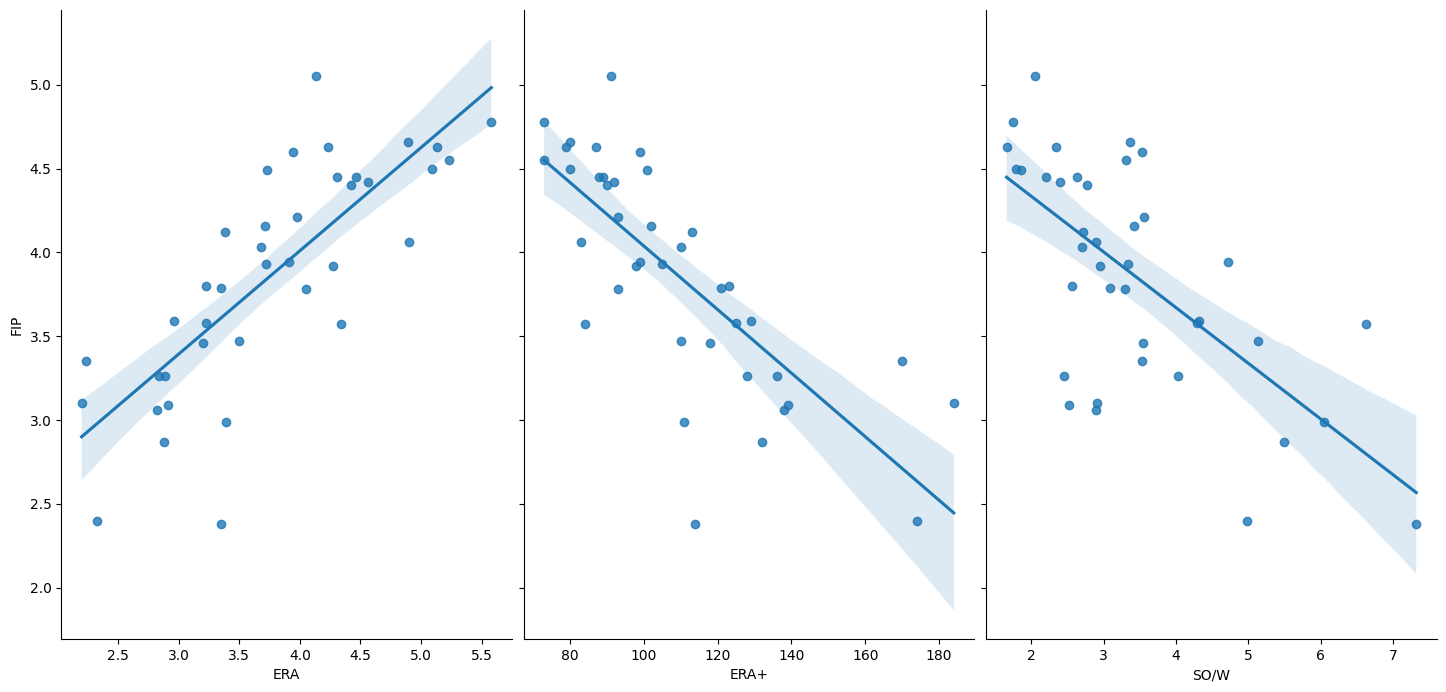

In [7]:
model, X = stepwise(al120h_num, 'FIP')

# Graficas
sns.pairplot(al120h_num, 
             x_vars=[column for column in X], 
             y_vars='FIP', height=7, aspect=0.7, kind='reg')

print(model.summary())

#### Interpretacion de los resultados

- R-squared: El R-cuadrado es una medida de qué tan bien se ajusta el modelo a los datos. En este caso, el R-cuadrado es 0.992, lo que significa que aproximadamente el 99.2% de la variabilidad en la variable dependiente (FIP) puede ser explicada por las variables independientes (ERA, ERA+ y SO/W) incluidas en el modelo.

- Adj. R-squared: El R-cuadrado ajustado es similar al R-cuadrado, pero tiene en cuenta la cantidad de variables independientes en el modelo y los grados de libertad. En este caso, el R-cuadrado ajustado es 0.991, lo que indica que el 99.1% de la variabilidad en la variable dependiente es explicada por las variables independientes ajustadas por el número de variables y grados de libertad.

- F-statistic: El estadístico F mide la significancia conjunta de todas las variables independientes en el modelo. Un valor alto del F-statistic y una probabilidad asociada baja indican que el modelo en general es estadísticamente significativo. En este caso, el F-statistic es 1468 y la probabilidad asociada es extremadamente baja (1.12e-37), lo que indica que el modelo en general es altamente significativo.

- Coeficientes: Los coeficientes estimados para cada variable independiente representan la contribución relativa de esa variable en la predicción de la variable dependiente. En este caso, los coeficientes son:

    - Coeficiente de ERA: 0.8795
    - Coeficiente de ERA+: 0.0104
    - Coeficiente de SO/W: -0.1734
    
    Estos coeficientes indican la dirección y magnitud de la relación entre cada variable independiente y la variable dependiente. Por ejemplo, un aumento de una unidad en ERA se asocia con un aumento de 0.8795 unidades en FIP, mientras que un aumento de una unidad en ERA+ se asocia con un aumento de 0.0104 unidades en FIP, y un aumento de una unidad en SO/W se asocia con una disminución de 0.1734 unidades en FIP.

- P-values: Los valores p indican la significancia estadística de cada coeficiente. Un valor p bajo (generalmente menor a 0.05) indica que el coeficiente es estadísticamente significativo. En este caso, todos los coeficientes tienen valores p muy bajos, lo que sugiere que todas las variables independientes son estadísticamente significativas para predecir la variable dependiente FIP.

- Cond. No.: El número de condición es una medida de la multicolinealidad en el modelo. Un número de condición alto puede indicar una alta correlación entre las variables independientes. En este caso, el número de condición es 91.0, lo que sugiere una baja multicolinealidad en el modelo.

En resumen, el modelo de regresión lineal múltiple utilizado muestra un buen ajuste a los datos, con un alto R-cuadrado y coeficientes estadísticamente significativos para las variables independientes. Sin embargo, es importante tener en cuenta las suposiciones del modelo y considerar el contexto específico antes de realizar interpretaciones definitivas.

In [ ]:
rho = al120h_num.corr()

finaldf = [al120h_num[variable] for variable in 
           al120h_num if abs(rho['FIP'][variable]) > 0.7]
finaldf = pd.concat(finaldf, axis=1)

X = [finaldf[variable] for variable in finaldf if variable != 'FIP']
X = pd.concat(X, axis=1)
y = finaldf['FIP']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

for column in X:
    sm.graphics.plot_regress_exog(model, column, fig=plt.figure(figsize=(12, 8)))

print(model.summary())

## Ejercicio 2

### Análisis exploratorio de la variable **Age**, de los jugadores de la liga americana 

In [ ]:
nl = df.loc[df['Lg'] == 'NL']

age = nl['Age']
# Calcular estadísticos descriptivos univariados
mean = age.mean()  # media
median = age.median()  # mediana
mode = age.mode()  # moda
std = age.std()  # desviación estándar
rank = age.max() - age.min()  # rango
quantile = age.quantile([0.25, 0.5, 0.75])  # cuartiles
iqr = quantile[0.75] - quantile[0.25]  # rango intercuartílico


# Mostrar resultados
print('Estadísticos descriptivos univariados')
print('Media:', mean)
print('Mediana:', median)
print('Moda:', mode)
print('Desviación estándar:', std)
print('Rango:', rank)
print('Cuartiles:', quantile)
print('Rango intercuartílico:', iqr)
# Crear histograma
plt.hist(age, bins=10)
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Histograma de edad')

# Crear diagrama de caja
plt.figure()
plt.boxplot(age, vert=False)
plt.xlabel('Edad')
plt.title('Diagrama de caja de edad')

# Mostrar gráficos
plt.show()


### Análisis exploratorio de la variable **Age**, por equipos, de los jugadores de la liga americana

In [ ]:
# Agrupar los datos por equipo y calcular la media de la edad de los jugadores
nl_age = nl.groupby('Tm')['Age'].mean()

# Hacer un histograma de la edad media por equipo
plt.hist(nl_age)
plt.xlabel('Edad media')
plt.ylabel('Frecuencia')
plt.title('Histograma de la edad media por equipo de la Liga Nacional')
plt.show()

# Hacer un diagrama de caja de la edad de los jugadores por equipo
sns.boxplot(x='Tm', y='Age', data=nl)
plt.xlabel('Equipo')
plt.ylabel('Edad')
plt.title('Diagrama de caja de la edad de los jugadores por equipo de la Liga Nacional')
plt.show()


### Test Shapiro

In [ ]:
def test_shapiro(df, f):
    b = True
    # crear un bucle que recorra la lista
    for i in set(f):

        # seleccionar los datos de las edades de cada equipo
        ages = df[df['Tm'] == i]['Age']

        # realizar la prueba de Shapiro-Wilk
        _, p = shapiro(ages)

        # comparar el valor p con el nivel de significancia
        if p > 0.01:
            b = b and True
        else:
            print('Los datos del equipo %s no parecen normales' % i)
            b = b and False

    return b


### Test Bartlett

In [ ]:
def test_bartlett(df, f):
    ages=[]
    # crear un bucle que recorra la lista
    for i in set(f):

        # seleccionar los datos de las edades de cada equipo
        ages.append(df[df['Tm'] == i]['Age'])


    #realizar la prueba de Bartlett
    stat, p = bartlett(*ages)

    print('Bartlett Estadístico: %.3f, Valor p: %.3f' % (stat, p))

    #interpretar el valor p
    if p > 0.01:
        return True
    else:
        print('Las varianzas no parecen iguales')
        return False


### Test Dw

In [ ]:
def test_dw(r):
    dw = durbin_watson(r)

    print('Estadístico: %.3f' % dw)

    # interpretar el resultado
    if dw > 1.5 and dw < 2.5:
        return True
    else:
        print('Hay evidencia de autocorrelación')
        return False


### Anova

In [ ]:
def mean_age(f, age, nl):

    # Crear el modelo lineal
    model = ols('age ~ f', data=nl).fit()

    # Crear la tabla ANOVA
    table = sm.stats.anova_lm(model, typ=2)
    resid = model.resid

    # Obtener el valor p del test F
    p = table['PR(>F)'][0]

    print('ANOVA de un factor')

    print('El valor p es', p)

    if p >= 0.01 and test_shapiro(nl, f) and test_bartlett(nl, f) and test_dw(resid):
        print('No hay diferencias significativas entre las medias de los equipos')
    else:
        print('Hay diferencias significativas entre las medias de los equipos')


### Inciso a

In [ ]:
f = nl['Tm']

mean_age(f, age, nl)


### Inciso b

In [ ]:
new_nl = nl[nl['Tm'].isin(['PIT', 'SDP', 'WSN', 'ATL'])]
f = new_nl['Tm']
new_age = new_nl['Age']

mean_age(f, new_age, new_nl)


### Inciso c

In [ ]:
# Agrupar por equipo y calcular medias
new_nl = nl.groupby('Tm').mean()

# Transponer el dataframe
new_nl = new_nl.transpose()

# Convertir a array de numpy
X = new_nl.to_numpy()

# Reducir la dimensión a 2 componentes usando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Crear el árbol jerárquico usando AgglomerativeClustering con 4 clústeres
ac = AgglomerativeClustering(n_clusters=4)
C = ac.fit_predict(X_pca)

# Asignar clústeres a equipos
clusters = dict(zip(new_nl.columns, C))

# Visualizar los clústeres usando un gráfico de dispersión con seaborn
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=C, palette='Set1')
plt.show()
